> __Paper:__
Physics-informed neural networks: A deep learning framework for solving forward and
inverse problems involving nonlinear partial differential equations

> [Link](https://doi.org/10.1016/j.jcp.2018.10.045)

> In This notebook, estimate the parameters.

> We select the last 32 time steps of a 32 x 32 grid of a solution of ASDM. The Training dataset includes all grid's data point.

> The free parameters of the model are fixed.

> The goal here is overfitting the model to re-create the exact output from the mtrained model. Therefore, we can be sure about the code and the selected architecture.

In [1]:
%config Completer.use_jedi = False

In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"


In [3]:
np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, 
                 model_name,                 
                 x_obs, y_obs, t_obs, a_obs, s_obs, 
                 x_pde, y_pde, t_pde,
                 layers,
                 x_boundary_LB = None, y_boundary_LB = None, t_boundary_LB= None, 
                 x_boundary_TR= None, y_boundary_TR= None, t_boundary_TR= None,
                 model_params={},
                 storage_dir='./'): 
        
        self.model_name = model_name
        self.model_params = model_params
        self.storage_dir = storage_dir
        self.__saver__ = None
        
        if x_boundary_LB is None or \
           x_boundary_TR is None or \
           y_boundary_LB is None or \
           y_boundary_TR is None or \
           t_boundary_LB is None or \
           t_boundary_TR is None:
            self.flg_boundary = False
        else:
            self.flg_boundary = True
        
        
        with tf.device(txt_device):
                 
            X = np.concatenate([x_obs, y_obs, t_obs], 1)

            self.lb = X.min(0)
            self.ub = X.max(0)                        

            self.x_obs = X[:,0:1]
            self.y_obs = X[:,1:2]
            self.t_obs = X[:,2:3]

            self.a_obs = a_obs
            self.s_obs = s_obs
            
            X = np.concatenate([x_pde, y_pde, t_pde], 1)
            
            self.x_pde = x_pde
            self.y_pde = y_pde
            self.t_pde = t_pde
            
            self.lb = np.amin(np.c_[X.min(0), self.lb], 1)
            self.ub = np.amax(np.c_[X.max(0), self.ub], 1)
            
            self.x_pde = X[:,0:1]
            self.y_pde = X[:,1:2]
            self.t_pde = X[:,2:3]
            
            if self.flg_boundary:
                X = np.concatenate([x_boundary_LB, y_boundary_LB, t_boundary_LB], 1)
            
                self.lb = np.amin(np.c_[X.min(0), self.lb], 1)
                self.ub = np.amax(np.c_[X.max(0), self.ub], 1)
            
                self.x_boundary_LB = X[:,0:1]
                self.y_boundary_LB = X[:,1:2]
                self.t_boundary_LB = X[:,2:3]
            
            
                X = np.concatenate([x_boundary_TR, y_boundary_TR, t_boundary_TR], 1)
            
                self.lb = np.amin(np.c_[X.min(0), self.lb], 1)
                self.ub = np.amax(np.c_[X.max(0), self.ub], 1)
            
                self.x_boundary_TR = X[:,0:1]
                self.y_boundary_TR = X[:,1:2]
                self.t_boundary_TR = X[:,2:3]           

            self.layers = layers

            # Initialize NN
            self.weights, self.biases = self.initialize_NN(layers)        

            # Initialize parameters
            self.D_a = tf.Variable([1.0], dtype=tf.float32, 
                                   name="D_a", 
                                   constraint= lambda z: tf.clip_by_value(z, 1e-6, 1e10))#tf.constant(0.005, dtype=tf.float32)#
            self.D_s = tf.Variable([1.0], dtype=tf.float32, 
                                   name="D_s",
                                  constraint= lambda z: tf.clip_by_value(z, 1e-6, 1e10))#tf.constant(0.2, dtype=tf.float32)#
            self.sigma_a = tf.Variable([0.0], dtype=tf.float32,
                                      name="sigma_a",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.0, dtype=tf.float32, name="sigma_a")#
            self.sigma_s = tf.Variable([1.00], dtype=tf.float32, 
                                       name="sigma_s",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.02, dtype=tf.float32)#
            self.mu_a = tf.Variable([1.00], dtype=tf.float32, 
                                    name="mu_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_a = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_a",
                                    constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_s = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_s",
                                    constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.02, dtype=tf.float32)#
            self.kappa_a = tf.Variable([1.00], dtype=tf.float32,
                                       name="kappa_a",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.25, dtype=tf.float32)##

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_obs_tf = tf.placeholder(tf.float32, shape=[None, self.x_obs.shape[1]], name="x_obs_tf")
        self.y_obs_tf = tf.placeholder(tf.float32, shape=[None, self.y_obs.shape[1]], name="y_obs_tf")
        self.t_obs_tf = tf.placeholder(tf.float32, shape=[None, self.t_obs.shape[1]], name="t_obs_tf")

        self.a_obs_tf = tf.placeholder(tf.float32, shape=[None, self.a_obs.shape[1]], name="a_obs_tf")
        self.s_obs_tf = tf.placeholder(tf.float32, shape=[None, self.s_obs.shape[1]], name="s_obs_tf")
        
        
        self.x_pde_tf = tf.placeholder(tf.float32, shape=[None, self.x_pde.shape[1]], name="x_pde_tf")
        self.y_pde_tf = tf.placeholder(tf.float32, shape=[None, self.y_pde.shape[1]], name="y_pde_tf")
        self.t_pde_tf = tf.placeholder(tf.float32, shape=[None, self.t_pde.shape[1]], name="t_pde_tf")
        
        
        if self.flg_boundary:
            self.x_boundary_LB_tf = tf.placeholder(tf.float32, shape=[None, self.x_boundary_LB.shape[1]], name="x_boundary_LB_tf")
            self.y_boundary_LB_tf = tf.placeholder(tf.float32, shape=[None, self.y_boundary_LB.shape[1]], name="y_boundary_LB_tf")
            self.t_boundary_LB_tf = tf.placeholder(tf.float32, shape=[None, self.t_boundary_LB.shape[1]], name="t_boundary_LB_tf")
        
            self.x_boundary_TR_tf = tf.placeholder(tf.float32, shape=[None, self.x_boundary_TR.shape[1]], name="x_boundary_TR_tf")
            self.y_boundary_TR_tf = tf.placeholder(tf.float32, shape=[None, self.y_boundary_TR.shape[1]], name="y_boundary_TR_tf")
            self.t_boundary_TR_tf = tf.placeholder(tf.float32, shape=[None, self.t_boundary_TR.shape[1]], name="t_boundary_TR_tf")

        # Observations
        self.a_pred, self.s_pred = self.net_ASDM(self.x_obs_tf, self.y_obs_tf, self.t_obs_tf)
        # PDE's Residuals
        self.a_pde_pred, self.s_pde_pred = self.net_ASDM(self.x_pde_tf, self.y_pde_tf, self.t_pde_tf)
        self.a_res_pde, self.s_res_pde = self.net_grads(self.a_pde_pred, self.s_pde_pred, self.x_pde_tf, self.y_pde_tf, self.t_pde_tf)
        # Boundary conditions
        if self.flg_boundary:
            self.a_boundary_LB, self.s_boundary_LB = self.net_ASDM(self.x_boundary_LB_tf, self.y_boundary_LB_tf, self.t_boundary_LB_tf)
            self.a_boundary_TR, self.s_boundary_TR = self.net_ASDM(self.x_boundary_TR_tf, self.y_boundary_TR_tf, self.t_boundary_TR_tf)
        
        
        # Losses
        # Observation loss
        self.loss_obs = tf.reduce_sum(tf.square(self.a_obs_tf - self.a_pred)) + \
                        tf.reduce_sum(tf.square(self.s_obs_tf - self.s_pred)) 
        # PDE residuals loss
        self.loss_pde_a = tf.reduce_sum(tf.square(self.a_res_pde), name = "loss_pde_a")
        self.loss_pde_s = tf.reduce_sum(tf.square(self.s_res_pde), name = "loss_pde_s")
        # Boundary condition loss
        if self.flg_boundary:
            self.loss_boundary_a = tf.reduce_sum(tf.square(self.a_boundary_LB - self.a_boundary_TR)
                                                 ,name = "loss_boundary_a")
            self.loss_boundary_s = tf.reduce_sum(tf.square(self.s_boundary_LB - self.s_boundary_TR)
                                                 ,name = "loss_boundary_s")
        

        # Total loss
        self.loss = self.loss_obs + 100*self.loss_pde_a + 100*self.loss_pde_s
        if self.flg_boundary:
            self.loss +=  self.loss_boundary_a + self.loss_boundary_s
        # Optimiser
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        

        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_ASDM(self, x, y, t):        
        
        a_and_s = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        a = tf.slice(a_and_s, [0,0], [-1,1], name = "a_pred")              
        s = tf.slice(a_and_s, [0,1], [-1,1], name = "s_pred")                
        
        return a, s
    
    def net_grads(self, a, s, x, y, t):
        
        a_t = tf.gradients(a, t)[0]
        a_x = tf.gradients(a, x)[0]
        a_y = tf.gradients(a, y)[0]
        a_xx = tf.gradients(a_x, x)[0]
        a_yy = tf.gradients(a_y, y)[0]
        
        s_t = tf.gradients(s, t)[0]
        s_x = tf.gradients(s, x)[0]
        s_y = tf.gradients(s, y)[0]
        s_xx = tf.gradients(s_x, x)[0]
        s_yy = tf.gradients(s_y, y)[0]
        
        
        D_a = self.D_a
        D_s = self.D_s
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        f = a*a*s/(1 + kappa_a*a*a)
        f_a = a_t - (a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - (s_xx + s_yy) + rho_s*f - sigma_s
        
        return f_a, f_s
        
    
    def callback(self, loss, loss_obs, loss_pde_a, loss_pde_s, 
                 D_a, D_s, sigma_a, sigma_s,
                 rho_a, rho_s, mu_a, kappa_a,
                 loss_boundary_a = None, loss_boundary_s = None):
        print(f"loss: {loss.tolist()}, loss_obs: {loss_obs.tolist()},\n"
              f"loss_a: {loss_pde_a.tolist()}, loss_s: {loss_pde_s.tolist()},\n"
              f"loss_boundary_a: {loss_boundary_a.tolist() if loss_boundary_a is not None else 0}, "
              f"loss_boundary_s: {loss_boundary_s.tolist() if loss_boundary_s is not None else 0},\n"
              f"D_a: {D_a.tolist()}, D_s: {D_s.tolist()}\n"
              f"sigma_a: {sigma_a.tolist()}, sigma_s: {sigma_s.tolist()}\n"
              f"rho_a: {rho_a.tolist()}, rho_s: {rho_s.tolist()}\n"
              f"mu_a: {mu_a.tolist()}, kappa_a: {kappa_a.tolist()}\n")
        
      
    def train_batch(self, nIter, batch_size, early_stop_thresh = None, print_iter = 100):
        
        data_n = self.x_obs.shape[0]
        batch_steps = data_n//batch_size
        batch_steps = batch_steps + (data_n-1)//(batch_steps*batch_size)
        
        pde_n = self.x_pde.shape[0]
        pde_batch_size = pde_n//batch_steps        
        
        if self.flg_boundary:
            boundary_n = self.x_boundary_LB.shape[0]        
            boundary_batch_size = boundary_n//batch_steps
        
        
        data = np.concatenate([self.x_obs, self.y_obs, self.t_obs, self.a_obs, self.s_obs], 1)
        pde = np.concatenate([self.x_pde, self.y_pde, self.t_pde], 1)
        if self.flg_boundary:
            boundary_LB = np.concatenate([self.x_boundary_LB, self.y_boundary_LB, self.t_boundary_LB], 1)
            boundary_TR = np.concatenate([self.x_boundary_TR, self.y_boundary_TR, self.t_boundary_TR], 1)
        
        indices_data = np.array(list(range(data_n)))
        indices_pde = np.array(list(range(pde_n)))
        if self.flg_boundary:
            indices_boundary = np.array(list(range(boundary_n)))
        
        arr_total_loss = np.zeros(nIter)
        arr_total_loss_obs = np.zeros(nIter)
        arr_total_loss_pde_a = np.zeros(nIter)
        arr_total_loss_pde_s = np.zeros(nIter)
        if self.flg_boundary:
            arr_total_loss_boundary_a = np.zeros(nIter)
            arr_total_loss_boundary_s = np.zeros(nIter)
        
        arr_D_a = np.zeros(nIter)
        arr_D_s = np.zeros(nIter)
        arr_sigma_a = np.zeros(nIter)
        arr_sigma_s = np.zeros(nIter)
        arr_rho_a = np.zeros(nIter)
        arr_rho_s = np.zeros(nIter)
        arr_mu_a = np.zeros(nIter)
        arr_kappa_a = np.zeros(nIter)
        
        def _get_val(item):
            val = item.tolist()
            if type(val) is float:
                return val
            else:
                return val[0]
        
        start_time = time.time()
        for it in range(nIter):
            # Shuflle the batches in each epoch
            np.random.shuffle(indices_data)
            np.random.shuffle(indices_pde)
            if self.flg_boundary:
                np.random.shuffle(indices_boundary)
            
            total_loss = 0
            total_loss_obs = 0
            total_loss_pde_a = 0
            total_loss_pde_s = 0
            total_loss_boundary_a = 0
            total_loss_boundary_s = 0
            
            for batch in range(batch_steps):
                data_start = batch*batch_size
                data_end = (batch+1)*batch_size
                data_end = data_end - (data_end//data_n)*(data_end%data_n)
                
                pde_start = batch*pde_batch_size
                pde_end = (batch+1)*pde_batch_size
                #pde_end -= (pde_end//pde_n)*(pde_end%pde_n)                                
                if self.flg_boundary:
                    boundary_start = batch*boundary_batch_size
                    boundary_end = (batch+1)*boundary_batch_size
                #boundary_end -= (boundary_end//boundary_n)*(boundary_end%boundary_n) 
                # Correction for other batch at last step
                if batch == batch_steps-1:
                    if pde_end < pde_n:
                        pde_end = pde_n
                        
                    if self.flg_boundary and boundary_end < boundary_n:
                        boundary_end = boundary_n
                        
                
                #print(f"Batch:{batch}, data:{data_start}-{data_end}, "
                #     f"data:{pde_start}-{pde_end}, "
                #     f"data:{boundary_start}-{boundary_end}")
                
                batch_indices_data = indices_data[data_start:data_end]
                batch_indices_pde = indices_pde[pde_start:pde_end]
                if self.flg_boundary:
                    batch_indices_boundary = indices_boundary[boundary_start:boundary_end]
                
                tf_dict = {self.x_obs_tf: data[batch_indices_data, 0:1], 
                           self.y_obs_tf: data[batch_indices_data, 1:2], 
                           self.t_obs_tf: data[batch_indices_data, 2:3],
                           self.a_obs_tf: data[batch_indices_data, 3:4], 
                           self.s_obs_tf: data[batch_indices_data, 4:5],
                           self.x_pde_tf: pde[batch_indices_pde, 0:1],
                           self.y_pde_tf: pde[batch_indices_pde, 1:2],
                           self.t_pde_tf: pde[batch_indices_pde, 2:3]}
                if self.flg_boundary:
                    tf_dict = {**tf_dict , 
                               **{self.x_boundary_LB_tf: boundary_LB[batch_indices_boundary, 0:1],
                                  self.y_boundary_LB_tf: boundary_LB[batch_indices_boundary, 1:2],
                                  self.t_boundary_LB_tf: boundary_LB[batch_indices_boundary, 2:3],
                                  self.x_boundary_TR_tf: boundary_TR[batch_indices_boundary, 0:1],
                                  self.y_boundary_TR_tf: boundary_TR[batch_indices_boundary, 1:2],
                                  self.t_boundary_TR_tf: boundary_TR[batch_indices_boundary, 2:3]}
                              }
                
                
                self.sess.run(self.train_op_Adam, tf_dict)
            
                loss_value = _get_val(self.sess.run(self.loss, tf_dict))
                loss_obs_value = _get_val(self.sess.run(self.loss_obs, tf_dict))
                loss_pde_a_value = _get_val(self.sess.run(self.loss_pde_a, tf_dict))
                loss_pde_s_value = _get_val(self.sess.run(self.loss_pde_s, tf_dict))
                if self.flg_boundary:
                    loss_boundary_a_value = _get_val(self.sess.run(self.loss_boundary_a, tf_dict))
                    loss_boundary_s_value = _get_val(self.sess.run(self.loss_boundary_s, tf_dict))
                
                total_loss += loss_value
                total_loss_obs += loss_obs_value
                total_loss_pde_a += loss_pde_a_value
                total_loss_pde_s += loss_pde_s_value
                if self.flg_boundary:
                    total_loss_boundary_a += loss_boundary_a_value
                    total_loss_boundary_s += loss_boundary_s_value
                    
            D_a_value = _get_val(self.sess.run(self.D_a))
            D_s_value = _get_val(self.sess.run(self.D_s))             
            sigma_a_value = _get_val(self.sess.run(self.sigma_a))
            sigma_s_value = _get_val(self.sess.run(self.sigma_s))              
            rho_a_value = _get_val(self.sess.run(self.rho_a))
            rho_s_value = _get_val(self.sess.run(self.rho_s))
            mu_a_value = _get_val(self.sess.run(self.mu_a))
            kappa_a_value = _get_val(self.sess.run(self.kappa_a))
            
            arr_total_loss[it] = total_loss
            arr_total_loss_obs[it] = total_loss_obs
            arr_total_loss_pde_a[it] = total_loss_pde_a
            arr_total_loss_pde_s[it] = total_loss_pde_s
            if self.flg_boundary:
                arr_total_loss_boundary_a[it] = total_loss_boundary_a
                arr_total_loss_boundary_s[it] = total_loss_boundary_s
            arr_D_a[it] = D_a_value
            arr_D_s[it] = D_s_value            
            arr_sigma_a[it] = sigma_a_value
            arr_sigma_s[it] = sigma_s_value
            arr_rho_a[it] = rho_a_value
            arr_rho_s[it] = rho_s_value
            arr_mu_a[it] = mu_a_value
            arr_kappa_a[it] = kappa_a_value
            
            # Print
            if it % print_iter == 0:
                elapsed = time.time() - start_time                                                                
                print(f"It: {it}, loss:{total_loss:.2f}, loss_obs:{total_loss_obs:.8f}, \n"
                      f"loss_pde_a: {total_loss_pde_a:.8f}, loss_pde_s: {total_loss_pde_s:.8f}, \n"
                      f"loss_boundary_a: {total_loss_boundary_a:.8f}, loss_boundary_s: {total_loss_boundary_s:.8f}, \n"
                      f"D_a: {D_a_value:.8f}, D_s: {D_s_value:.8f}\n"
                      f"sigma_a: {sigma_a_value:.8f}, sigma_s: {sigma_s_value:.8f}\n"
                      f"rho_a: {rho_a_value:.8f}, rho_s: {rho_s_value:.8f}\n"
                      f"mu_a: {mu_a_value:.8f}, kappa_a: {kappa_a_value:.8f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
            # early stop
            if early_stop_thresh is not None and early_stop_thresh >= total_loss:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time                                                                                                    
                print(f"It: {it}, loss:{total_loss:.2f}, loss_obs:{total_loss_obs:.8f}, \n"
                      f"loss_pde_a: {total_loss_pde_a:.8f}, loss_pde_s: {total_loss_pde_s:.8f}, \n"
                      f"loss_boundary_a: {total_loss_boundary_a:.8f}, loss_boundary_s: {total_loss_boundary_s:.8f}, \n"
                      f"D_a: {D_a_value:.8f}, D_s: {D_s_value:.8f}\n"
                      f"sigma_a: {sigma_a_value:.8f}, sigma_s: {sigma_s_value:.8f}\n"
                      f"rho_a: {rho_a_value:.8f}, rho_s: {rho_s_value:.8f}\n"
                      f"mu_a: {mu_a_value:.8f}, kappa_a: {kappa_a_value:.8f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time() 
                
                losses = {'total_loss': arr_total_loss[:(it+1)],
                          'loss_obs': arr_total_loss_obs[:(it+1)],
                          'loss_pde_a': arr_total_loss_pde_a[:(it+1)],
                          'loss_pde_s': arr_total_loss_pde_s[:(it+1)]                          
                          }
                if self.flg_boundary:
                    losses = {**losses, 
                              **{'loss_boundary_a': arr_total_loss_boundary_a[:(it+1)],
                                 'loss_boundary_s': arr_total_loss_boundary_s[:(it+1)]}
                             }
                params = {'D_a': arr_D_a[:(it+1)], 'D_s': arr_D_s[:(it+1)],
                          'sigma_a': arr_sigma_a[:(it+1)] , 'sigma_s': arr_sigma_s[:(it+1)],
                          'rho_a' : arr_rho_a[:(it+1)], 'rho_s' : arr_rho_s[:(it+1)],
                          'mu_a': arr_mu_a[:(it+1)], 'kappa_a': arr_kappa_a[:(it+1)]}
                
                return (losses, params)    
                    
            
        # end for it
        losses = {'total_loss': arr_total_loss,
                  'loss_obs': arr_total_loss_obs,
                  'loss_pde_a': arr_total_loss_pde_a,
                  'loss_pde_s': arr_total_loss_pde_s
                 }
        if self.flg_boundary:
            losses = {**losses, 
                      **{'loss_boundary_a': arr_total_loss_boundary_a,
                         'loss_boundary_s': arr_total_loss_boundary_s}
                    }
        
        params = {'D_a': arr_D_a, 'D_s': arr_D_s,
                  'sigma_a': arr_sigma_a , 'sigma_s': arr_sigma_s,
                  'rho_a' : arr_rho_a, 'rho_s' : arr_rho_s, 'mu_a': arr_mu_a, 'kappa_a': arr_kappa_a}
        
        
        return (losses, params)
                
            
        
        
    def minimise(self, max_iter = None, f_tol = None):
        if max_iter is not None:
            self.optimizer.optimizer_kwargs['options']['maxiter'] = max_iter
            
        if f_tol is not None:
            self.optimizer.optimizer_kwargs['options']['f_tol'] = f_tol
        
        if self.flg_boundary:
            tf_dict = {self.x_obs_tf: self.x_obs, self.y_obs_tf: self.y_obs, self.t_obs_tf: self.t_obs,
                       self.a_obs_tf: self.a_obs, self.s_obs_tf: self.s_obs,
                       self.x_pde_tf: self.x_pde, self.y_pde_tf: self.y_pde, self.t_pde_tf: self.t_pde,
                       self.x_boundary_LB_tf: self.x_boundary_LB, 
                       self.y_boundary_LB_tf: self.y_boundary_LB, 
                       self.t_boundary_LB_tf: self.t_boundary_LB,
                       self.x_boundary_TR_tf: self.x_boundary_TR, 
                       self.y_boundary_TR_tf: self.y_boundary_TR, 
                       self.t_boundary_TR_tf: self.t_boundary_TR
                      }
            self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.loss_obs, self.loss_pde_a, self.loss_pde_s,                                           
                                           self.D_a, self.D_s,
                                           self.sigma_a, self.sigma_s,
                                           self.rho_a, self.rho_s,
                                           self.mu_a, self.kappa_a,
                                           self.loss_boundary_a, 
                                           self.loss_boundary_s],
                                loss_callback = self.callback)      
                      
        else:
            tf_dict = {self.x_obs_tf: self.x_obs, self.y_obs_tf: self.y_obs, self.t_obs_tf: self.t_obs,
                   self.a_obs_tf: self.a_obs, self.s_obs_tf: self.s_obs,
                   self.x_pde_tf: self.x_pde, self.y_pde_tf: self.y_pde, self.t_pde_tf: self.t_pde}
            self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.loss_obs, self.loss_pde_a, self.loss_pde_s,                                           
                                           self.D_a, self.D_s,
                                           self.sigma_a, self.sigma_s,
                                           self.rho_a, self.rho_s,
                                           self.mu_a, self.kappa_a],
                                loss_callback = self.callback)        
            
            
        
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_obs_tf: x_star, self.y_obs_tf: y_star, self.t_obs_tf: t_star,
                   self.x_pde_tf: self.x_pde, self.y_pde_tf: self.y_pde, self.t_pde_tf: self.t_pde}
        if self.flg_boundary:
            tf_dict = {**tf_dict,
                       **{self.x_boundary_LB_tf: self.x_boundary_LB, 
                          self.y_boundary_LB_tf: self.y_boundary_LB, 
                          self.t_boundary_LB_tf: self.t_boundary_LB,
                          self.x_boundary_TR_tf: self.x_boundary_TR, 
                          self.y_boundary_TR_tf: self.y_boundary_TR, 
                          self.t_boundary_TR_tf: self.t_boundary_TR}
                      }
        
        a_star = self.sess.run(self.a_pred, tf_dict)
        s_star = self.sess.run(self.s_pred, tf_dict)
        
        return a_star, s_star
    
    def __getstate__(self):
        # Save tensorflow graph
        if self.__saver__ is None:
            saver = tf.train.Saver(max_to_keep=1)
        else:
            saver = tf.train.Saver(max_to_keep=1, saver_def=self.__saver__)
           
        import os
        if not os.path.exists(self.storage_dir):
            os.makedirs(self.storage_dir)
            
        saver.save(self.sess, f"{self.storage_dir}{self.model_name}")
        self.__saver__ = saver.as_saver_def()
        # Copy the object's state from self.__dict__ which contains
        # all our instance attributes. Always use the dict.copy()
        # method to avoid modifying the original state.
        state = self.__dict__.copy()
        
        # Remove the unpicklable entries and save the op_name for storage        
        for item in ['sess', 'optimizer', 'optimizer_Adam']:            
            del state[item]
            
        no_op_dict = {}
        for item in ['train_op_Adam']:
            no_op_dict[item] = getattr(self, item).name
            del state[item]
            
        state['no_op_dict'] = no_op_dict
        
        tensors_dict = {}
        
        for i,w in enumerate(self.weights):
            tensors_dict[f"weights_{i}"] = w.name
        del state['weights']
        
        for i,b in enumerate(self.biases):
            tensors_dict[f"biases_{i}"] = b.name
        del state['biases']   
        
        for item in ['D_a', 'D_s', 'sigma_a', 'sigma_s', 
                     'mu_a', 'rho_a', 'rho_s', 'kappa_a', 'x_obs_tf', 
                     'y_obs_tf', 't_obs_tf', 'a_obs_tf', 's_obs_tf', 'x_pde_tf', 
                     'y_pde_tf', 't_pde_tf',
                     'a_pred', 's_pred', 'a_pde_pred', 
                     's_pde_pred', 'a_res_pde', 's_res_pde',
                     'loss_obs', 'loss_pde_a', 'loss_pde_s', 'loss']:            
            tensors_dict[item] = getattr(self, item).name            
            del state[item]
            
        if self.flg_boundary:
            for item in ['x_boundary_LB_tf', 'y_boundary_LB_tf', 
                         't_boundary_LB_tf', 'x_boundary_TR_tf', 'y_boundary_TR_tf', 
                         't_boundary_TR_tf', 'a_boundary_LB', 's_boundary_LB', 
                         'a_boundary_TR', 's_boundary_TR', 'loss_boundary_a', 'loss_boundary_s']:
                tensors_dict[item] = getattr(self, item).name            
                del state[item]
            
        state['tensors_dict'] = tensors_dict
                    
            
        return state
    
    def __setstate__(self, state):
        # Restore instance attributes 
        self.__dict__.update(state)
        # Restore the tensorflow graph
        sess=tf.Session()
        saver = tf.train.import_meta_graph(f"{self.storage_dir}{self.model_name}.meta")
        saver.restore(sess,tf.train.latest_checkpoint(self.storage_dir))
        self.sess = sess        
        #
        graph = tf.get_default_graph()        
        tensors_dict = state['tensors_dict']
        
        weights = {}
        biases = {}
        for att_name in tensors_dict.keys():
            if not att_name.startswith("weights") and not att_name.startswith("biases"):
                op_name = tensors_dict[att_name]
                self.__dict__[att_name] = graph.get_tensor_by_name(op_name)
            if att_name.startswith("weights"):
                op_name = tensors_dict[att_name]
                weights[op_name] = graph.get_tensor_by_name(op_name)
            if att_name.startswith("biases"):
                op_name = tensors_dict[att_name]
                biases[op_name] = graph.get_tensor_by_name(op_name)
                
        self.weights = [weights[key] for key in sorted(weights.keys())]
        self.biases = [biases[key] for key in sorted(biases.keys())]
                
        del state['tensors_dict']  
        
        # Optimiser
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        

          
        no_op_dict = state['no_op_dict']
        for att_name in no_op_dict.keys():
            op_name = no_op_dict[att_name]
            self.__dict__[att_name] = graph.get_operation_by_name(op_name)
        
        del state['no_op_dict']
        

In [4]:
import pickle
def save_model(model):
    import os
    if not os.path.exists(model.storage_dir):
        os.makedirs(model.storage_dir)
    with open(f"{model.storage_dir}{model.model_name}.pkl", 'wb') as f:
        pickle.dump(model, f)

def load_model(model_pkl_path):
    with open(model_pkl_path, 'rb') as f:
        model = pickle.load(f)
    return model

def merge_stats(dict_stats1, dict_stats2):
    ret = {}
    for key in dict_stats1.keys():
        ret[key] = np.r_[dict_stats1[key], dict_stats2[key]]
    return ret

def print_vals(name, value, actual=None):
    def _get_val(item):
        val = item.tolist()
        if type(val) is float:
            return val
        else:
            return val[0]
    value = _get_val(value)
    
    if actual is not None and actual > 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f}, "
              f"relative: %{100*np.abs(actual-value)/(actual):0.8f}")
    elif actual is not None and actual == 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f} ")
        
    else:
        print(f"{name}: {value:0.8f}")
        
def print_model(model):
    D_a = model.sess.run(model.D_a)
    D_s = model.sess.run(model.D_s)
    sigma_s = model.sess.run(model.sigma_s)
    rho_s = model.sess.run(model.rho_s)

    sigma_a = model.sess.run(model.sigma_a)
    rho_a = model.sess.run(model.rho_a)
    mu_a = model.sess.run(model.mu_a)
    kappa_a = model.sess.run(model.kappa_a)


    print_vals("D_s", D_s, 0.2)
    print_vals("sigma_s", sigma_s*0.2, 0.02)
    print_vals("rho_s", rho_s*0.2, 0.02)
    print()
    print_vals("D_a", D_a, 0.005)
    print_vals("sigma_a", sigma_a*0.005, 0.0)
    print_vals("rho_a", rho_a*0.005,0.01)
    print_vals("mu_a", mu_a*0.005, 0.01 )
    print_vals("kappa_a", kappa_a, 0.25)

In [5]:
#layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x_domain = L*np.linspace(0,1,x_size)
y_domain = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x_domain, y_domain, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

boundary_x_LB = np.concatenate((x_domain, 
                                np.repeat(x_domain[0], y_size)))
boundary_x_TR = np.concatenate((x_domain, 
                                np.repeat(x_domain[-1], y_size))) 

boundary_y_LB = np.concatenate((np.repeat(y_domain[0], x_size),
                                y_domain))
boundary_y_TR = np.concatenate((np.repeat(y_domain[-1], x_size),
                                y_domain)) 

boundary_XX_LB = np.tile(boundary_x_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_XX_TR = np.tile(boundary_x_TR.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_YY_LB = np.tile(boundary_y_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_YY_TR = np.tile(boundary_y_TR.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_TT = np.repeat(t_star[-T:], (x_size + y_size))[:, np.newaxis] # T x (x_size + y_size), 1


def create_dataset(training_data_size =  T*16,
                   pde_data_size =  (T*N)//(32),
                   boundary_data_size = ((x_size + y_size)*T)//(8),
                   with_boundary = True,
                   signal_to_noise = 0):
    
    ##########################################
    # Including noise
    if signal_to_noise > 0:
        signal_amp_a = (np.max(AA)-np.min(AA))/2.0
        signal_amp_s = (np.max(SS)-np.min(SS))/2.0  
        sigma_a =  signal_amp_a*signal_to_noise
        sigma_s =  signal_amp_s*signal_to_noise
    # Observed data
    idx_data = np.random.choice(N*T, training_data_size, replace=False)
    # PDE colocations
    idx_pde = np.random.choice(N*T, pde_data_size, replace=False)
    # Periodic boundary condition
    idx_boundary = np.random.choice((x_size + y_size)*T, boundary_data_size, replace=False)
    
    ret = {'x_obs': x[idx_data,:],
            'y_obs': y[idx_data,:],
            't_obs': t[idx_data,:],
            'a_obs': a[idx_data,:],
            's_obs': s[idx_data,:],
            'x_pde':   x[idx_pde,:],
            'y_pde':   y[idx_pde,:],
            't_pde':   t[idx_pde,:]}
    
    if signal_to_noise > 0:        
        ret['a_obs'] += sigma_a * np.random.randn(len(idx_data), a.shape[1])
        ret['s_obs'] += sigma_s * np.random.randn(len(idx_data), s.shape[1])
    
    if with_boundary:
        ret = {**ret,
               **{'x_boundary_LB': boundary_XX_LB[idx_boundary],
                  'x_boundary_TR': boundary_XX_TR[idx_boundary],
                  'y_boundary_LB': boundary_YY_LB[idx_boundary],
                  'y_boundary_TR': boundary_YY_TR[idx_boundary],
                  't_boundary_LB': boundary_TT[idx_boundary],
                  't_boundary_TR': boundary_TT[idx_boundary]}
              }
    return ret



# Model regularised
###  On average, 32 data points per time-step
### without boundary condition
### with %20 noise

In [6]:
# Training
model_params = {'training_data_size': T*32,
                  'pde_data_size': (T*N)//(32),
                  'boundary_data_size':((x_size + y_size)*T)//(8),
                  'signal_to_noise':0.2,
                  'with_boundary':False}

training_dataset = create_dataset(**model_params)

model_reg = PhysicsInformedNN("model_reg",                           
                          layers = layers,                                    
                          model_params = model_params,
                          storage_dir = "./models_repo/model_reg/",
                          **training_dataset)

losses,  params_estimates = \
model_reg.train_batch(30000, batch_size=len(model_reg.x_obs)//8,  early_stop_thresh=10, print_iter=1000)

model_reg.model_params['losses'] = losses
model_reg.model_params['params_estimates'] = params_estimates

It: 0, loss:1668288.25, loss_obs:43257.58789062, 
loss_pde_a: 17.04248232, loss_pde_s: 16233.26416016, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00565861, sigma_s: 0.99200171
rho_a: 0.99806535, rho_s: 1.00451696
mu_a: 0.99334711, kappa_a: 0.99644727, 
Time:3.96

It: 1000, loss:4988.12, loss_obs:4983.62536621, 
loss_pde_a: 0.01617921, loss_pde_s: 0.02879442, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.10447345, sigma_s: 0.90786904
rho_a: 1.08524776, rho_s: 1.25403214
mu_a: 0.89077848, kappa_a: 0.75445324, 
Time:540.42

It: 2000, loss:4986.50, loss_obs:4984.13153076, 
loss_pde_a: 0.00979499, loss_pde_s: 0.01384673, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.11939680, sigma_s: 0.88647228
rho_a: 1.07250655, rho_s: 1.24402833
mu_a: 0.88451463, kappa_a: 0.78208941, 
Time:539.60

It: 3000, loss:4988.79, loss_obs:

It: 26000, loss:4029.39, loss_obs:3659.75543213, 
loss_pde_a: 3.32415810, loss_pde_s: 0.37217831, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.15279764
rho_a: 0.00215827, rho_s: 0.35136515
mu_a: 0.00000000, kappa_a: 1.90256202, 
Time:533.64

It: 27000, loss:4056.98, loss_obs:3735.53024292, 
loss_pde_a: 2.97917998, loss_pde_s: 0.23536040, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.12366813
rho_a: 0.00000000, rho_s: 0.27783862
mu_a: 0.00000000, kappa_a: 1.85097873, 
Time:532.89

It: 28000, loss:4039.96, loss_obs:3707.38494873, 
loss_pde_a: 3.07111120, loss_pde_s: 0.25467748, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.11805183
rho_a: 0.00008069, rho_s: 0.25014347
mu_a: 0.00000000, kappa_a: 1.68290830, 
Time:534.08

It: 29000, loss:4023.92, loss_obs:

In [7]:
save_model(model_reg)
#model_reg = load_model("./models_repo/model_reg/model_reg.pkl")
print_model(model_reg)

D_s: 1.00000000, actual: 0.200, difference: 0.80000000, relative: %400.00000000
sigma_s: 0.02213067, actual: 0.020, difference: 0.00213067, relative: %10.65333150
rho_s: 0.04180435, actual: 0.020, difference: 0.02180435, relative: %109.02177319

D_a: 1.00000000, actual: 0.005, difference: 0.99500000, relative: %19900.00000000
sigma_a: 0.00000000, actual: 0.000, difference: 0.00000000 
rho_a: 0.00000040, actual: 0.010, difference: 0.00999960, relative: %99.99601706
mu_a: 0.00000000, actual: 0.010, difference: 0.01000000, relative: %100.00000000
kappa_a: 1.38329279, actual: 0.250, difference: 1.13329279, relative: %453.31711769


In [12]:
losses2,  params_estimates2 = \
model_reg.train_batch(12000, batch_size=len(model_reg.x_obs)//8,  early_stop_thresh=10, print_iter=1000)


It: 0, loss:4009.23, loss_obs:3670.39633179, 
loss_pde_a: 3.12355003, loss_pde_s: 0.26476987, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.11092532
rho_a: 0.00018652, rho_s: 0.20872855
mu_a: 0.00000000, kappa_a: 1.38341296, 
Time:0.55

It: 1000, loss:3977.10, loss_obs:3624.59103394, 
loss_pde_a: 3.25196519, loss_pde_s: 0.27310932, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.10300446
rho_a: 0.00000000, rho_s: 0.18503910
mu_a: 0.00000000, kappa_a: 1.27512610, 
Time:515.56

It: 2000, loss:3758.68, loss_obs:3392.23242188, 
loss_pde_a: 3.32600728, loss_pde_s: 0.33844347, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.07673640
rho_a: 0.00000000, rho_s: 0.13292558
mu_a: 0.00000000, kappa_a: 1.21596074, 
Time:516.34

It: 3000, loss:3566.61, loss_obs:3197.4154

In [22]:
model_reg.model_params['losses'] = merge_stats(model_reg.model_params['losses'], losses2)
model_reg.model_params['params_estimates'] = merge_stats(model_reg.model_params['params_estimates'],
                                                       params_estimates2)

In [14]:
save_model(model_reg)
#model_reg = load_model("./models_repo/model_reg/model_reg.pkl")
print_model(model_reg)

D_s: 1.00000000, actual: 0.200, difference: 0.80000000, relative: %400.00000000
sigma_s: 0.01720794, actual: 0.020, difference: 0.00279206, relative: %13.96028548
rho_s: 0.01477012, actual: 0.020, difference: 0.00522988, relative: %26.14940275

D_a: 1.00000000, actual: 0.005, difference: 0.99500000, relative: %19900.00000000
sigma_a: 0.00000000, actual: 0.000, difference: 0.00000000 
rho_a: 0.00482796, actual: 0.010, difference: 0.00517204, relative: %51.72039606
mu_a: 0.00553236, actual: 0.010, difference: 0.00446764, relative: %44.67635173
kappa_a: 0.13758704, actual: 0.250, difference: 0.11241296, relative: %44.96518373


In [29]:
losses3,  params_estimates3 = \
model_reg.train_batch(2000, batch_size=len(model_reg.x_obs)//8,  early_stop_thresh=10, print_iter=100)


It: 0, loss:853.08, loss_obs:758.08531952, 
loss_pde_a: 0.59632524, loss_pde_s: 0.35364493, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08611292
rho_a: 0.96559596, rho_s: 0.07374933
mu_a: 1.10653949, kappa_a: 0.13759074, 
Time:0.57

It: 100, loss:854.75, loss_obs:756.61811829, 
loss_pde_a: 0.62456699, loss_pde_s: 0.35675320, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08608159
rho_a: 0.96819758, rho_s: 0.07382892
mu_a: 1.10883021, kappa_a: 0.13796382, 
Time:52.06

It: 200, loss:855.08, loss_obs:756.65260315, 
loss_pde_a: 0.62787322, loss_pde_s: 0.35642711, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08585482
rho_a: 0.97076470, rho_s: 0.07417484
mu_a: 1.11114097, kappa_a: 0.13821480, 
Time:52.64

It: 300, loss:866.34, loss_obs:755.70443726, 
loss_p

In [30]:
model_reg.model_params['losses'] = merge_stats(model_reg.model_params['losses'], losses3)
model_reg.model_params['params_estimates'] = merge_stats(model_reg.model_params['params_estimates'],
                                                       params_estimates3)

In [37]:
print_model(model_reg)

D_s: 1.00000000, actual: 0.200, difference: 0.80000000, relative: %400.00000000
sigma_s: 0.01724784, actual: 0.020, difference: 0.00275216, relative: %13.76079619
rho_s: 0.01498451, actual: 0.020, difference: 0.00501549, relative: %25.07746909

D_a: 1.00000000, actual: 0.005, difference: 0.99500000, relative: %19900.00000000
sigma_a: 0.00000000, actual: 0.000, difference: 0.00000000 
rho_a: 0.00505839, actual: 0.010, difference: 0.00494161, relative: %49.41608049
mu_a: 0.00573492, actual: 0.010, difference: 0.00426508, relative: %42.65081361
kappa_a: 0.14594992, actual: 0.250, difference: 0.10405008, relative: %41.62003398


In [38]:
losses3,  params_estimates3 = \
model_reg.train_batch(20000, batch_size=len(model_reg.x_obs)//8,  early_stop_thresh=10, print_iter=100)


It: 0, loss:842.58, loss_obs:744.40402985, 
loss_pde_a: 0.64850415, loss_pde_s: 0.33326666, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08616386
rho_a: 1.01168513, rho_s: 0.07487601
mu_a: 1.14702439, kappa_a: 0.14597334, 
Time:0.56

It: 100, loss:834.33, loss_obs:742.54968262, 
loss_pde_a: 0.59116212, loss_pde_s: 0.32662677, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08626928
rho_a: 1.01381874, rho_s: 0.07503743
mu_a: 1.14878678, kappa_a: 0.14620195, 
Time:53.68

It: 200, loss:829.03, loss_obs:742.37207794, 
loss_pde_a: 0.53801494, loss_pde_s: 0.32856264, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08605217
rho_a: 1.01580501, rho_s: 0.07512309
mu_a: 1.15055728, kappa_a: 0.14670171, 
Time:53.05

It: 300, loss:839.91, loss_obs:742.06802368, 
loss_p

It: 2600, loss:815.60, loss_obs:730.39095306, 
loss_pde_a: 0.54998636, loss_pde_s: 0.30206645, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08644649
rho_a: 1.06040776, rho_s: 0.07614174
mu_a: 1.18970752, kappa_a: 0.15421544, 
Time:51.13

It: 2700, loss:847.22, loss_obs:730.30368042, 
loss_pde_a: 0.85397908, loss_pde_s: 0.31514337, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00003686, sigma_s: 0.08654200
rho_a: 1.06219912, rho_s: 0.07602310
mu_a: 1.19126010, kappa_a: 0.15437977, 
Time:51.15

It: 2800, loss:816.81, loss_obs:728.44351196, 
loss_pde_a: 0.58082201, loss_pde_s: 0.30288989, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08644927
rho_a: 1.06389117, rho_s: 0.07612988
mu_a: 1.19275999, kappa_a: 0.15462430, 
Time:51.80

It: 2900, loss:810.72, loss_obs:728.92875671, 

It: 5200, loss:802.07, loss_obs:719.15139008, 
loss_pde_a: 0.54723403, loss_pde_s: 0.28196211, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08690127
rho_a: 1.10255861, rho_s: 0.07697318
mu_a: 1.22632611, kappa_a: 0.16115268, 
Time:51.26

It: 5300, loss:803.21, loss_obs:718.93582916, 
loss_pde_a: 0.55949311, loss_pde_s: 0.28325648, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08677302
rho_a: 1.10407376, rho_s: 0.07732985
mu_a: 1.22770154, kappa_a: 0.16131209, 
Time:51.21

It: 5400, loss:840.45, loss_obs:719.36867523, 
loss_pde_a: 0.91427723, loss_pde_s: 0.29655390, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00010372, sigma_s: 0.08673688
rho_a: 1.10566223, rho_s: 0.07719167
mu_a: 1.22906995, kappa_a: 0.16138609, 
Time:52.34

It: 5500, loss:791.56, loss_obs:717.56756592, 

It: 7800, loss:774.91, loss_obs:710.09436035, 
loss_pde_a: 0.39099786, loss_pde_s: 0.25714268, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08706535
rho_a: 1.13983846, rho_s: 0.07794648
mu_a: 1.25832760, kappa_a: 0.16718130, 
Time:51.84

It: 7900, loss:783.97, loss_obs:710.16729736, 
loss_pde_a: 0.47646128, loss_pde_s: 0.26158208, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08713289
rho_a: 1.14114141, rho_s: 0.07801699
mu_a: 1.25963557, kappa_a: 0.16736178, 
Time:52.37

It: 8000, loss:800.46, loss_obs:709.40951538, 
loss_pde_a: 0.64512578, loss_pde_s: 0.26538471, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08712592
rho_a: 1.14245892, rho_s: 0.07798281
mu_a: 1.26085114, kappa_a: 0.16759166, 
Time:51.65

It: 8100, loss:782.36, loss_obs:709.46556091, 

It: 10400, loss:766.02, loss_obs:701.83675385, 
loss_pde_a: 0.39786841, loss_pde_s: 0.24396010, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08709437
rho_a: 1.17249763, rho_s: 0.07888567
mu_a: 1.28620994, kappa_a: 0.17247304, 
Time:51.71

It: 10500, loss:766.33, loss_obs:702.61033630, 
loss_pde_a: 0.39381200, loss_pde_s: 0.24335212, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08722930
rho_a: 1.17371523, rho_s: 0.07873335
mu_a: 1.28721404, kappa_a: 0.17255077, 
Time:51.26

It: 10600, loss:771.22, loss_obs:701.77402496, 
loss_pde_a: 0.45252642, loss_pde_s: 0.24197197, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08724870
rho_a: 1.17482829, rho_s: 0.07887151
mu_a: 1.28825271, kappa_a: 0.17278175, 
Time:51.68

It: 10700, loss:767.96, loss_obs:702.247451

It: 13000, loss:782.90, loss_obs:696.92494965, 
loss_pde_a: 0.62141347, loss_pde_s: 0.23833151, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08753142
rho_a: 1.20064139, rho_s: 0.07908950
mu_a: 1.31004417, kappa_a: 0.17700888, 
Time:52.20

It: 13100, loss:758.07, loss_obs:696.14157867, 
loss_pde_a: 0.38883442, loss_pde_s: 0.23040848, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08738070
rho_a: 1.20177948, rho_s: 0.07935677
mu_a: 1.31088340, kappa_a: 0.17698658, 
Time:51.32

It: 13200, loss:781.90, loss_obs:696.43949127, 
loss_pde_a: 0.61466192, loss_pde_s: 0.23994942, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00007006, sigma_s: 0.08712251
rho_a: 1.20279014, rho_s: 0.07961514
mu_a: 1.31163394, kappa_a: 0.17720790, 
Time:51.73

It: 13300, loss:757.40, loss_obs:695.999320

It: 15600, loss:763.12, loss_obs:691.65102386, 
loss_pde_a: 0.48707828, loss_pde_s: 0.22758202, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00005663, sigma_s: 0.08735533
rho_a: 1.22554922, rho_s: 0.07987285
mu_a: 1.33056259, kappa_a: 0.18105084, 
Time:50.69

It: 15700, loss:750.21, loss_obs:690.85015106, 
loss_pde_a: 0.36969062, loss_pde_s: 0.22387916, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00001262, sigma_s: 0.08745236
rho_a: 1.22646129, rho_s: 0.07983429
mu_a: 1.33145344, kappa_a: 0.18104358, 
Time:51.28

It: 15800, loss:750.73, loss_obs:691.44942474, 
loss_pde_a: 0.37068693, loss_pde_s: 0.22211291, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08747564
rho_a: 1.22738922, rho_s: 0.07988620
mu_a: 1.33210135, kappa_a: 0.18119472, 
Time:51.11

It: 15900, loss:765.83, loss_obs:691.029678

It: 18200, loss:752.83, loss_obs:686.48281097, 
loss_pde_a: 0.44429136, loss_pde_s: 0.21921996, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08759880
rho_a: 1.24756885, rho_s: 0.08034732
mu_a: 1.34925747, kappa_a: 0.18418339, 
Time:52.57

It: 18300, loss:741.92, loss_obs:686.79446411, 
loss_pde_a: 0.33679736, loss_pde_s: 0.21442611, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08769468
rho_a: 1.24840093, rho_s: 0.08033092
mu_a: 1.34977019, kappa_a: 0.18433999, 
Time:51.93

It: 18400, loss:752.46, loss_obs:686.11051941, 
loss_pde_a: 0.44539884, loss_pde_s: 0.21810086, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08778087
rho_a: 1.24918056, rho_s: 0.08014636
mu_a: 1.35039282, kappa_a: 0.18461812, 
Time:52.13

It: 18500, loss:755.76, loss_obs:686.253616

In [39]:
model_reg.model_params['losses'] = merge_stats(model_reg.model_params['losses'], losses3)
model_reg.model_params['params_estimates'] = merge_stats(model_reg.model_params['params_estimates'],
                                                       params_estimates3)

In [45]:
print_model(model_reg)

D_s: 1.00000000, actual: 0.200, difference: 0.80000000, relative: %400.00000000
sigma_s: 0.01748935, actual: 0.020, difference: 0.00251065, relative: %12.55323403
rho_s: 0.01615148, actual: 0.020, difference: 0.00384852, relative: %19.24261674

D_a: 1.00000000, actual: 0.005, difference: 0.99500000, relative: %19900.00000000
sigma_a: 0.00000007, actual: 0.000, difference: 0.00000007 
rho_a: 0.00630848, actual: 0.010, difference: 0.00369152, relative: %36.91517971
mu_a: 0.00680385, actual: 0.010, difference: 0.00319615, relative: %31.96145631
kappa_a: 0.18651716, actual: 0.250, difference: 0.06348284, relative: %25.39313436


In [ ]:
losses3,  params_estimates3 = \
model_reg.train_batch(20000, batch_size=len(model_reg.x_obs)//8,  early_stop_thresh=10, print_iter=100)

It: 0, loss:743.68, loss_obs:684.46435547, 
loss_pde_a: 0.37917010, loss_pde_s: 0.21293810, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08749035
rho_a: 1.26166773, rho_s: 0.08075361
mu_a: 1.36080062, kappa_a: 0.18656024, 
Time:0.56

It: 100, loss:741.08, loss_obs:683.85395813, 
loss_pde_a: 0.36081059, loss_pde_s: 0.21143009, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08780631
rho_a: 1.26246274, rho_s: 0.08052251
mu_a: 1.36141026, kappa_a: 0.18641831, 
Time:51.85

It: 200, loss:745.59, loss_obs:683.08850098, 
loss_pde_a: 0.41359844, loss_pde_s: 0.21138772, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08768336
rho_a: 1.26320243, rho_s: 0.08059113
mu_a: 1.36201286, kappa_a: 0.18661314, 
Time:51.62

It: 300, loss:743.78, loss_obs:683.50137329, 
loss_p

It: 2600, loss:733.09, loss_obs:679.16373444, 
loss_pde_a: 0.33563311, loss_pde_s: 0.20364221, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08770248
rho_a: 1.28050125, rho_s: 0.08101120
mu_a: 1.37630939, kappa_a: 0.18938492, 
Time:51.64

It: 2700, loss:736.05, loss_obs:679.80149078, 
loss_pde_a: 0.35929549, loss_pde_s: 0.20320125, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000234, sigma_s: 0.08769044
rho_a: 1.28123164, rho_s: 0.08092657
mu_a: 1.37698615, kappa_a: 0.18931805, 
Time:51.32

It: 2800, loss:736.50, loss_obs:679.71537018, 
loss_pde_a: 0.36340189, loss_pde_s: 0.20446117, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08779101
rho_a: 1.28192830, rho_s: 0.08097772
mu_a: 1.37758410, kappa_a: 0.18945101, 
Time:51.13

It: 2900, loss:738.55, loss_obs:679.74474335, 

It: 5200, loss:735.27, loss_obs:676.80597687, 
loss_pde_a: 0.38374144, loss_pde_s: 0.20092751, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08797318
rho_a: 1.29786611, rho_s: 0.08120529
mu_a: 1.39075339, kappa_a: 0.19190440, 
Time:55.33

It: 5300, loss:740.03, loss_obs:676.60969543, 
loss_pde_a: 0.43267013, loss_pde_s: 0.20152224, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08784553
rho_a: 1.29847968, rho_s: 0.08136719
mu_a: 1.39136946, kappa_a: 0.19193248, 
Time:54.24

It: 5400, loss:736.94, loss_obs:675.64811707, 
loss_pde_a: 0.41176603, loss_pde_s: 0.20117342, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00005657, sigma_s: 0.08781336
rho_a: 1.29918814, rho_s: 0.08132587
mu_a: 1.39190495, kappa_a: 0.19188152, 
Time:53.24

It: 5500, loss:738.43, loss_obs:676.39009094, 

It: 7800, loss:767.71, loss_obs:673.90583038, 
loss_pde_a: 0.73254634, loss_pde_s: 0.20549295, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00004915, sigma_s: 0.08781500
rho_a: 1.31381071, rho_s: 0.08167209
mu_a: 1.40408874, kappa_a: 0.19400151, 
Time:52.42



In [40]:
model = model_reg
losses = model.model_params['losses']
params_estimates = model.model_params['params_estimates']

In [41]:

total_loss = losses['total_loss']
total_loss_obs = losses['loss_obs']
total_loss_pde_a = losses['loss_pde_a']
total_loss_pde_s = losses['loss_pde_s']
if model.flg_boundary:
    total_loss_boundary_a = losses['loss_boundary_a']
    total_loss_boundary_s = losses['loss_boundary_s']

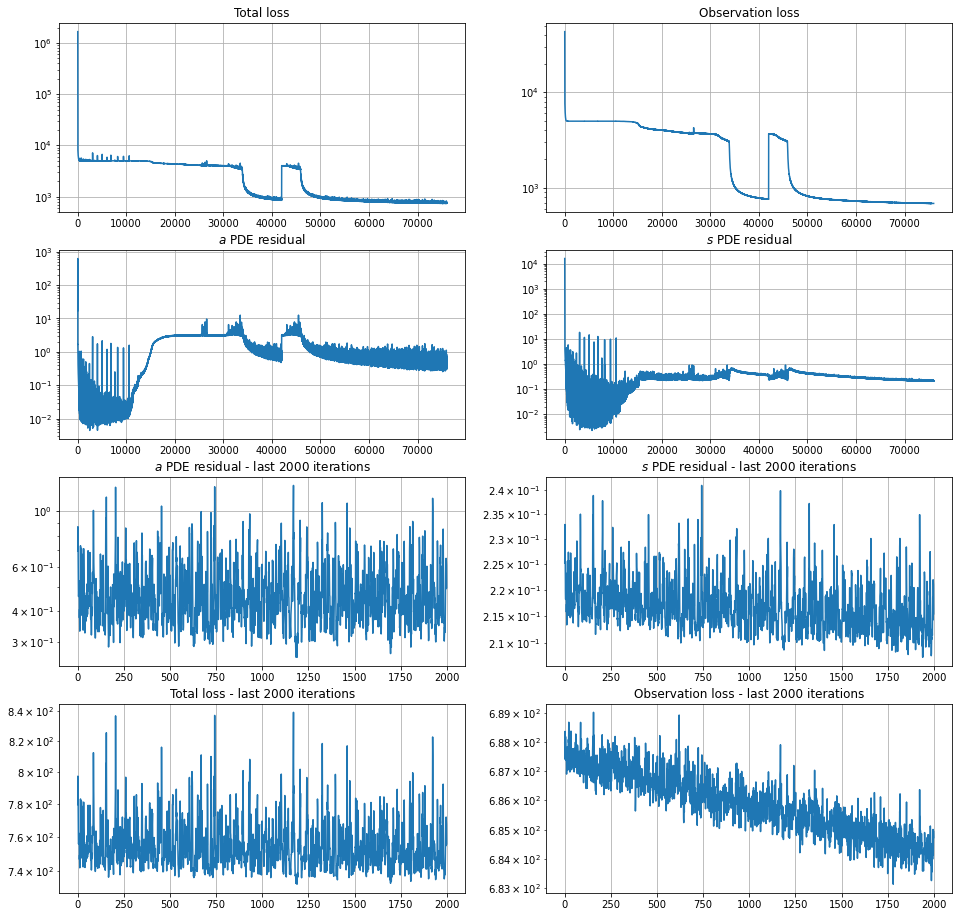

In [42]:
start = 0
end = len(total_loss)
_ = plt.figure(figsize=(16,16))

plt.subplot(4,2,1)
plt.plot(total_loss[start:end])
plt.yscale('log')
plt.title(r"Total loss")
plt.grid()

plt.subplot(4,2,2)
plt.plot(total_loss_obs[start:end])
plt.yscale('log')
plt.title(r"Observation loss")
plt.grid()


plt.subplot(4,2,3)
plt.plot(total_loss_pde_a[start:end])
plt.yscale('log')
plt.title(r"$a$ PDE residual")
plt.grid()

plt.subplot(4,2,4)
plt.plot(total_loss_pde_s[start:end])
plt.yscale('log')
plt.title(r"$s$ PDE residual")
plt.grid()

plt.subplot(4,2,5)
plt.plot(total_loss_pde_a[-2000:])
plt.yscale('log')
plt.title(r"$a$ PDE residual - last 2000 iterations")
plt.grid()

plt.subplot(4,2,6)
plt.plot(total_loss_pde_s[-2000:])
plt.yscale('log')
plt.title(r"$s$ PDE residual - last 2000 iterations")
plt.grid()


plt.subplot(4,2,7)
plt.plot(total_loss[-2000:])
plt.yscale('log')
plt.title(r"Total loss - last 2000 iterations")
plt.grid()

plt.subplot(4,2,8)
plt.plot(total_loss_obs[-2000:])
plt.yscale('log')
plt.title(r"Observation loss - last 2000 iterations")
plt.grid()

plt.show()

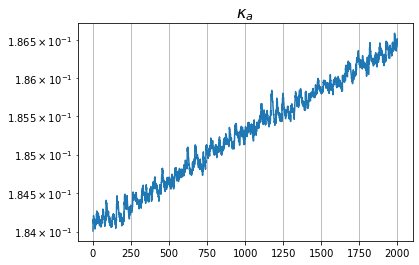

In [43]:
plt.plot(params_estimates['kappa_a'][-2000:])
plt.title(r"$\kappa_a$", fontsize=16)
plt.yscale('log')
#plt.ylim([0,1])
plt.grid()
plt.show()

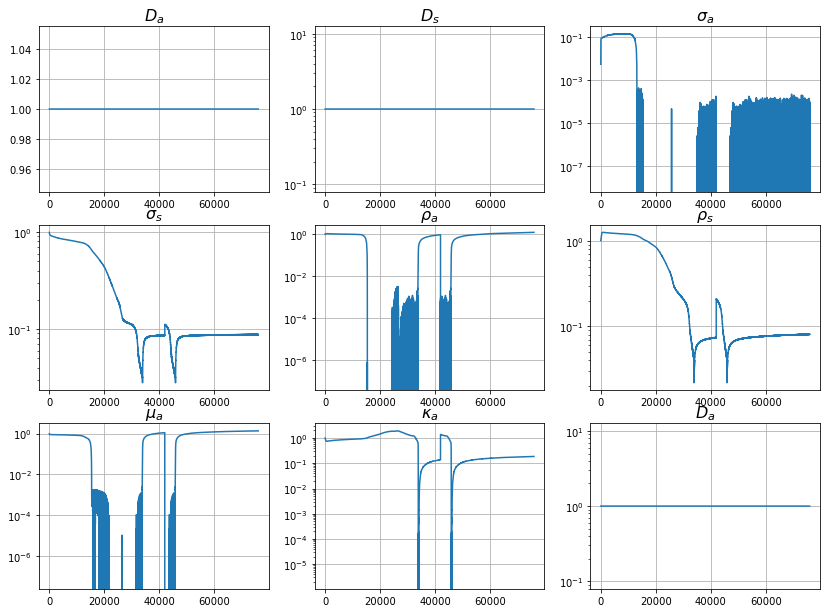

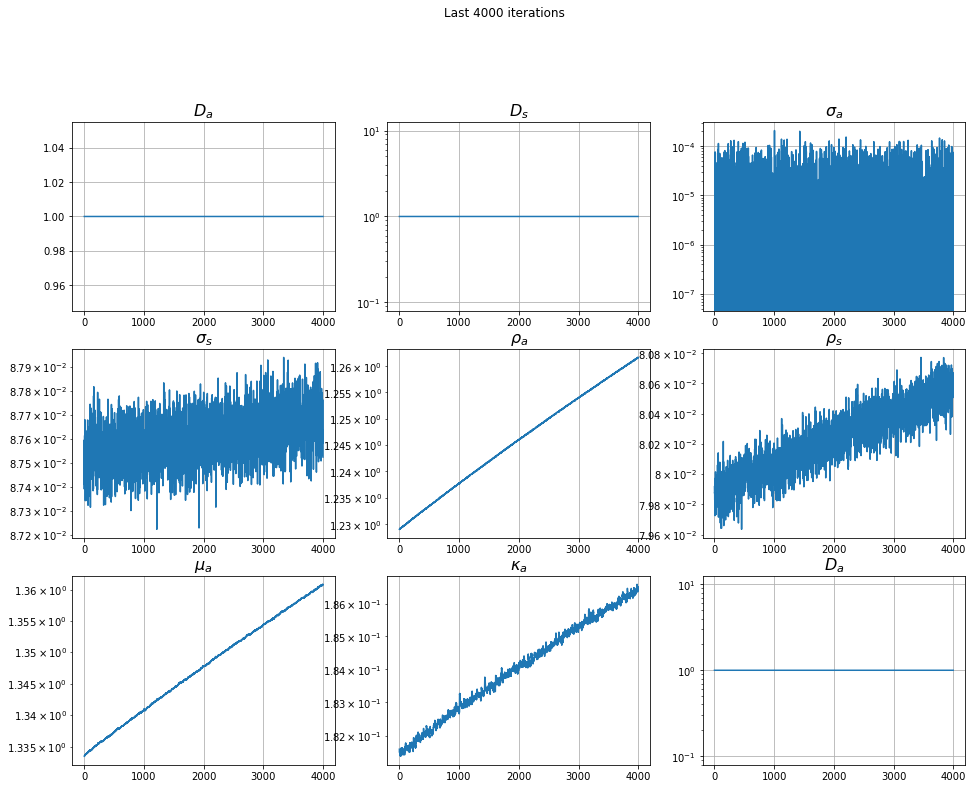

In [44]:
start = 0
end = -1
_ = plt.figure(figsize=(14,14))

plt.subplot(4,3,1)
plt.plot(params_estimates['D_a'][start:end])
plt.title(r"$D_a$", fontsize=16)
#plt.yscale('log')
plt.grid()

plt.subplot(4,3,2)
plt.plot(params_estimates['D_s'][start:end])
plt.title(r"$D_s$", fontsize=16)
plt.yscale('log')
plt.grid()


plt.subplot(4,3,3)
plt.plot(params_estimates['sigma_a'][start:end])
plt.title(r"$\sigma_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.subplot(4,3,4)
plt.plot(params_estimates['sigma_s'][start:end])
plt.title(r"$\sigma_s$", fontsize=16)
plt.yscale('log')
#plt.ylim([0.005,.04])
plt.grid()

plt.subplot(4,3,5)
plt.plot(params_estimates['rho_a'][start:end])
plt.title(r"$\rho_a$", fontsize=16)
plt.yscale('log')
plt.grid()


plt.subplot(4,3,6)
plt.plot(params_estimates['rho_s'][start:end])
plt.title(r"$\rho_s$", fontsize=16)
plt.yscale('log')
#plt.ylim([0.0,.05])
plt.grid()


plt.subplot(4,3,7)
plt.plot(params_estimates['mu_a'][start:end])
plt.title(r"$\mu_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.subplot(4,3,8)
plt.plot(params_estimates['kappa_a'][start:end])
plt.title(r"$\kappa_a$", fontsize=16)
plt.yscale('log')
#plt.ylim([0,1])
plt.grid()

plt.subplot(4,3,9)
plt.plot(params_estimates['D_a'][start:end])
plt.title(r"$D_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.show()

start = -4000
end = -1
_ = plt.figure(figsize=(16,16))

plt.suptitle(f"Last {-start} iterations")

plt.subplot(4,3,1)
plt.plot(params_estimates['D_a'][start:end])
plt.title(r"$D_a$", fontsize=16)
#plt.yscale('log')
plt.grid()

plt.subplot(4,3,2)
plt.plot(params_estimates['D_s'][start:end])
plt.title(r"$D_s$", fontsize=16)
plt.yscale('log')
plt.grid()


plt.subplot(4,3,3)
plt.plot(params_estimates['sigma_a'][start:end])
plt.title(r"$\sigma_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.subplot(4,3,4)
plt.plot(params_estimates['sigma_s'][start:end])
plt.title(r"$\sigma_s$", fontsize=16)
plt.yscale('log')
#plt.ylim([0.005,.04])
plt.grid()

plt.subplot(4,3,5)
plt.plot(params_estimates['rho_a'][start:end])
plt.title(r"$\rho_a$", fontsize=16)
plt.yscale('log')
plt.grid()


plt.subplot(4,3,6)
plt.plot(params_estimates['rho_s'][start:end])
plt.title(r"$\rho_s$", fontsize=16)
plt.yscale('log')
#plt.ylim([0.0,.05])
plt.grid()


plt.subplot(4,3,7)
plt.plot(params_estimates['mu_a'][start:end])
plt.title(r"$\mu_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.subplot(4,3,8)
plt.plot(params_estimates['kappa_a'][start:end])
plt.title(r"$\kappa_a$", fontsize=16)
plt.yscale('log')
#plt.ylim([0,1])
plt.grid()

plt.subplot(4,3,9)
plt.plot(params_estimates['D_a'][start:end])
plt.title(r"$D_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.show()


# Estimated parameters

In [80]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = -1#-1
t_test = 50000#t_star[index]#0#5000000


TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [81]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
a_2 = a_2.reshape((x_size,y_size))
s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_obs_tf: x_2, model.y_obs_tf: y_2, model.t_obs_tf: t_2, 
           model.a_obs_tf:data[0, :, :, index].flatten()[:, np.newaxis],
           model.s_obs_tf:data[1, :, :, index].flatten()[:, np.newaxis],
           model.x_pde_tf: model.x_pde, model.y_pde_tf: model.y_pde, model.t_pde_tf: model.t_pde}
if model.flg_boundary:
    tf_dict = {**tf_dict,
               **{model.x_boundary_LB_tf: model.x_boundary_LB, 
                  model.y_boundary_LB_tf: model.y_boundary_LB, 
                  model.t_boundary_LB_tf: model.t_boundary_LB,
                  model.x_boundary_TR_tf: model.x_boundary_TR, 
                  model.y_boundary_TR_tf: model.y_boundary_TR, 
                  model.t_boundary_TR_tf: model.t_boundary_TR}
              }
print( f"Loss_a           : {model.sess.run(model.loss_pde_a, tf_dict):.8f}")
print( f"Loss_s           : {model.sess.run(model.loss_pde_s, tf_dict):.8f}")
print( f"Loss_obs         : {model.sess.run(model.loss_obs, tf_dict):.8f}")
if model.flg_boundary:
    print( f"Loss_boundary_a  : {model.sess.run(model.loss_boundary_a, tf_dict):.8f}")
    print( f"Loss_boundary_s  : {model.sess.run(model.loss_boundary_s, tf_dict):.8f}")
print( f"Loss             : {model.sess.run(model.loss, tf_dict):.8f}")

Loss_a           : 24.18018723
Loss_s           : 3.95667982
Loss_obs         : 9.96291637
Loss             : 38.09978485


In [82]:
print(np.sum(np.power(a_2 - data[0, :, :, index],2)))
print(np.sum(np.power(s_2 - data[1, :, :, index],2)))

9.394651068477483
0.5682651071943747


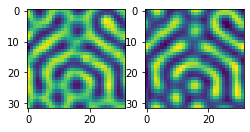

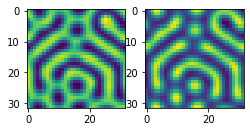

In [83]:

plt.subplot(131)
plt.imshow(a_2)
plt.subplot(132)
plt.imshow(s_2)
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, index].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, index].reshape((x_size,y_size)))
plt.show()